In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

files = ['./data/2004.csv', './data/2005.csv', './data/2006.csv','./data/2007.csv', './data/2008.csv', './data/2009.csv','./data/2010.csv', './data/2011.csv', './data/2012.csv','./data/2013.csv', './data/2014.csv', './data/2015.csv','./data/2016.csv', './data/2017.csv', './data/2018.csv','./data/2019.csv', './data/2020.csv', './data/2021.csv','./data/2022.csv', './data/2023.csv', './data/2024.csv']  

data = pd.read_csv(files[10])

data

,Date,Price
0,2013-04-09,-18.00
1,2013-04-10,-6.50
2,2013-04-11,-4.50
3,2013-04-12,-26.25
4,2013-04-13,-26.25
...,...,...
516,2014-09-07,14.00
517,2014-09-08,17.25
518,2014-09-09,16.50
519,2014-09-10,15.25


In [24]:
data = data[['Date', 'Price']]
data

,Date,Price
0,2013-04-09,-18.00
1,2013-04-10,-6.50
2,2013-04-11,-4.50
3,2013-04-12,-26.25
4,2013-04-13,-26.25
...,...,...
516,2014-09-07,14.00
517,2014-09-08,17.25
518,2014-09-09,16.50
519,2014-09-10,15.25


In [40]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

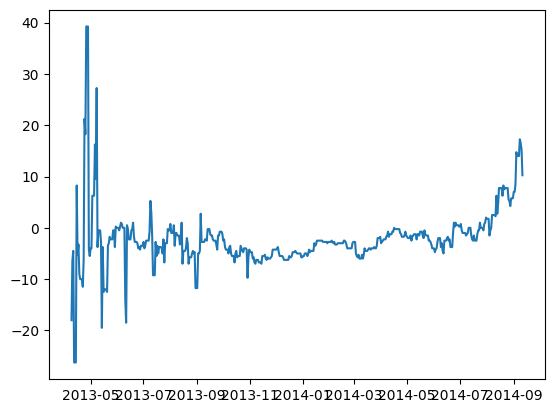

In [25]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Price'])

In [26]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,
2013-04-16,-5.25,8.25,-26.25,-26.25,-26.25,-4.50,-6.50,-18.00
2013-04-17,-3.25,-5.25,8.25,-26.25,-26.25,-26.25,-4.50,-6.50
2013-04-18,-9.00,-3.25,-5.25,8.25,-26.25,-26.25,-26.25,-4.50
2013-04-19,-10.00,-9.00,-3.25,-5.25,8.25,-26.25,-26.25,-26.25
2013-04-20,-10.00,-10.00,-9.00,-3.25,-5.25,8.25,-26.25,-26.25
...,...,...,...,...,...,...,...,...
2014-09-07,14.00,14.00,14.00,14.75,8.50,7.00,7.00,5.75
2014-09-08,17.25,14.00,14.00,14.00,14.75,8.50,7.00,7.00
2014-09-09,16.50,17.25,14.00,14.00,14.00,14.75,8.50,7.00


In [27]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ -5.25,   8.25, -26.25, ...,  -4.5 ,  -6.5 , -18.  ],
       [ -3.25,  -5.25,   8.25, ..., -26.25,  -4.5 ,  -6.5 ],
       [ -9.  ,  -3.25,  -5.25, ..., -26.25, -26.25,  -4.5 ],
       ...,
       [ 16.5 ,  17.25,  14.  , ...,  14.75,   8.5 ,   7.  ],
       [ 15.25,  16.5 ,  17.25, ...,  14.  ,  14.75,   8.5 ],
       [ 10.25,  15.25,  16.5 , ...,  14.  ,  14.  ,  14.75]])

In [28]:
shifted_df_as_np.shape

(514, 8)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.51489362, -0.05531915, -1.        , ..., -0.33587786,
        -0.39694656, -0.7480916 ],
       [-0.44680851, -0.51489362,  0.05343511, ..., -1.        ,
        -0.33587786, -0.39694656],
       [-0.64255319, -0.44680851, -0.35877863, ..., -1.        ,
        -1.        , -0.33587786],
       ...,
       [ 0.22553191,  0.25106383,  0.22900763, ...,  0.2519084 ,
         0.0610687 ,  0.01526718],
       [ 0.18297872,  0.22553191,  0.32824427, ...,  0.22900763,
         0.2519084 ,  0.0610687 ],
       [ 0.01276596,  0.18297872,  0.30534351, ...,  0.22900763,
         0.22900763,  0.2519084 ]])

In [30]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((514, 7), (514,))

In [31]:
# we did this because we have to go back to front
X = dc(np.flip(X, axis=1))
X

array([[-0.7480916 , -0.39694656, -0.33587786, ..., -1.        ,
        -1.        , -0.05531915],
       [-0.39694656, -0.33587786, -1.        , ..., -1.        ,
         0.05343511, -0.51489362],
       [-0.33587786, -1.        , -1.        , ...,  0.05343511,
        -0.35877863, -0.44680851],
       ...,
       [ 0.01526718,  0.0610687 ,  0.2519084 , ...,  0.22900763,
         0.22900763,  0.25106383],
       [ 0.0610687 ,  0.2519084 ,  0.22900763, ...,  0.22900763,
         0.32824427,  0.22553191],
       [ 0.2519084 ,  0.22900763,  0.22900763, ...,  0.32824427,
         0.30534351,  0.18297872]])

In [32]:
split_index = int(len(X) * 0.95)

split_index

488

In [33]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((488, 7), (26, 7), (488,), (26,))

In [34]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((488, 7, 1), (26, 7, 1), (488, 1), (26, 1))

In [35]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([488, 7, 1]),
 torch.Size([26, 7, 1]),
 torch.Size([488, 1]),
 torch.Size([26, 1]))

In [36]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [37]:
train_dataset

In [42]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [43]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.211
***************************************************

Epoch: 2

Val Loss: 0.203
***************************************************

Epoch: 3

Val Loss: 0.192
***************************************************

Epoch: 4

Val Loss: 0.187
***************************************************

Epoch: 5

Val Loss: 0.178
***************************************************

Epoch: 6

Val Loss: 0.171
***************************************************

Epoch: 7

Val Loss: 0.162
***************************************************

Epoch: 8

Val Loss: 0.153
***************************************************

Epoch: 9

Val Loss: 0.140
***************************************************

Epoch: 10

Val Loss: 0.124
***************************************************

Epoch: 11

Val Loss: 0.111
***************************************************

Epoch: 12

Val Loss: 0.098
***************************************************

Epoch: 13

Val Loss: 0.080
**********************

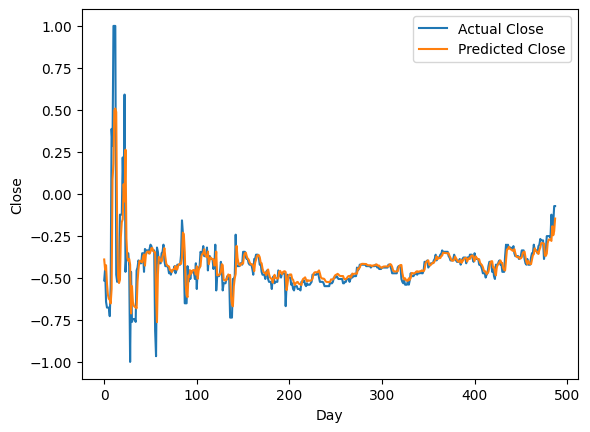

In [50]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [51]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([-1.58754227e+00, -3.35908654e+00, -2.59813028e+00, -5.87410622e+00,
       -7.76372415e+00, -8.46350268e+00, -8.63279414e+00, -9.27516286e+00,
       -6.74933058e+00,  1.24122122e+01,  1.51928291e+01,  2.44967192e+01,
        2.48123252e+01,  2.41918951e+01,  3.27724975e+00, -4.69561432e+00,
       -5.71232431e+00, -5.14853538e+00,  2.35693700e+00,  4.92283219e+00,
        5.44849557e+00,  1.15707650e+01,  8.55110399e+00,  1.76095619e+01,
        2.11425889e+00, -1.26469631e+00, -1.80051046e+00, -1.48598647e+00,
       -2.51332347e+00, -1.10267076e+01, -6.24735494e+00, -9.00563140e+00,
       -9.68689957e+00, -9.87573792e+00, -9.90398147e+00, -1.01300472e+01,
       -5.45126890e+00, -3.30704932e+00, -1.84439380e+00, -1.81053866e+00,
       -1.95126266e+00, -2.08797275e+00, -1.04907640e+00, -6.93896830e-01,
       -2.66379815e+00, -8.15593943e-01, -3.19123089e-01, -1.98663853e-01,
       -2.10804500e-01, -5.66008583e-01, -2.09768850e-01,  3.92267324e-01,
        4.17276986e-01, -

In [52]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-5.24999925e+00, -3.25000019e+00, -9.00000055e+00, -1.00000001e+01,
       -1.00000001e+01, -1.00000001e+01, -1.15000003e+01, -6.25000053e+00,
        2.12499997e+01,  1.82500002e+01,  3.92500000e+01,  3.92500000e+01,
        3.92500000e+01, -4.24999972e+00, -5.49999957e+00, -4.00000027e+00,
       -4.00000027e+00,  6.24999995e+00,  6.24999995e+00,  6.24999995e+00,
        1.62499999e+01,  9.50000001e+00,  2.72500004e+01, -3.74999995e+00,
       -5.00000164e-01, -5.00000164e-01, -5.00000164e-01, -2.75000042e+00,
       -1.95000000e+01, -3.74999995e+00, -1.24999998e+01, -1.19999991e+01,
       -1.19999991e+01, -1.19999991e+01, -1.24999998e+01, -3.49999963e+00,
       -2.99999987e+00, -1.75000001e+00, -2.24999978e+00, -2.24999978e+00,
       -2.24999978e+00, -5.00000164e-01, -5.00000164e-01, -3.74999995e+00,
        2.49999922e-01, -3.98606061e-07, -3.98606061e-07, -3.98606061e-07,
       -5.00000164e-01,  2.49999922e-01,  1.00000001e+00,  7.49999687e-01,
       -3.98606061e-07, -

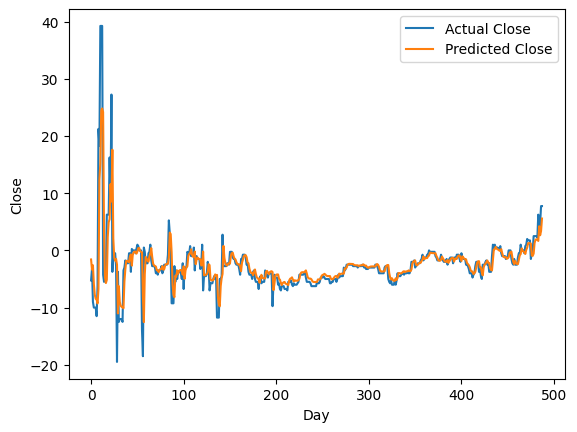

In [53]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [54]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 6.114496  ,  6.10794681,  5.98966305,  4.944186  ,  5.93674514,
        5.7638022 ,  5.85492096,  5.86776021,  5.86188861,  5.85533767,
        4.40214745,  3.84844012,  3.12706352,  3.98408217,  4.30165138,
        4.38295161,  5.19684329,  5.39027422,  6.35701566, 10.50496894,
       10.85933172, 10.63001112, 10.39578016, 12.1914928 , 12.10092469,
       11.23915064])

In [55]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 7.7499999 ,  7.7499999 ,  6.24999995,  8.25      ,  7.50000002,
        7.7499999 ,  7.7499999 ,  7.7499999 ,  7.7499999 ,  5.50000008,
        5.2500002 ,  4.2499998 ,  5.74999997,  5.74999997,  5.74999997,
        7.00000004,  7.00000004,  8.49999999, 14.75000012, 14.00000003,
       14.00000003, 14.00000003, 17.24999982, 16.50000017, 15.24999988,
       10.24999999])

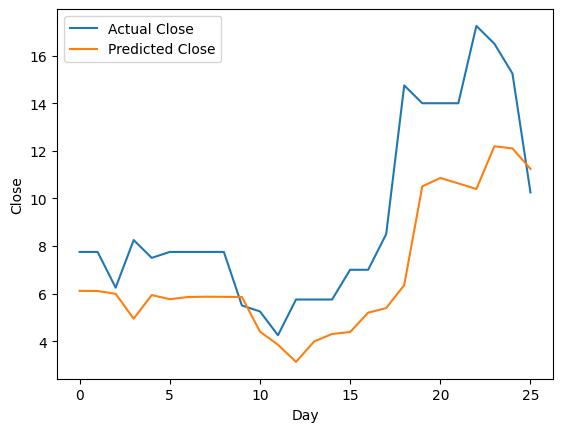

In [56]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
